Name: Antony Krymski

Username: agk-123

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [41]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, LSTM, Reshape, MaxPooling2D, LayerNormalization, TimeDistributed, GRU, Lambda, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import keras

# Generating sin random data

(500000, 1)


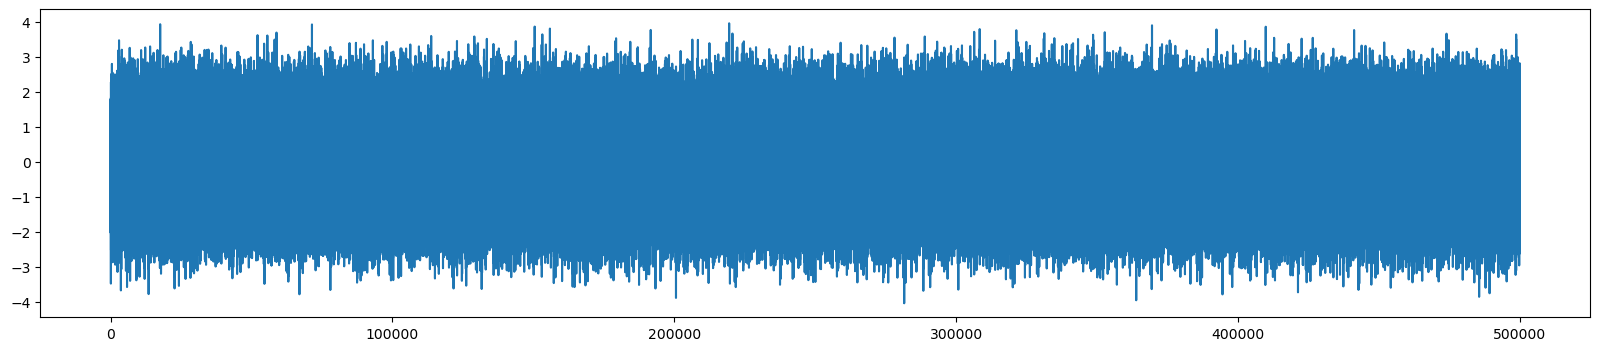

In [3]:
# generate some sample data
data = np.sin(np.arange(0, 500_000, 1))

# data = np.random.normal(np.arange(0, 100000, 1), 10000)
# add some noise
data += np.random.normal(0, .75, data.shape)
data = np.expand_dims(data, axis=-1)
print(data.shape)
# plot with large size 
plt.figure(figsize=(20, 4))
plt.plot(data[:, 0])

# Normalising

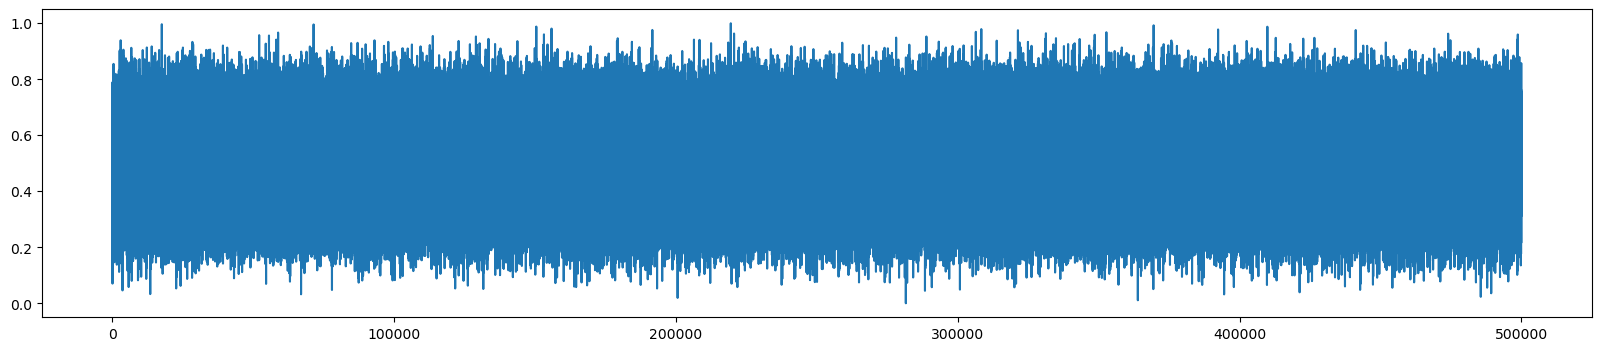

In [4]:
# scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
plt.figure(figsize=(20, 4)) 
plt.plot(data[:, 0])

# Splitting

In [23]:
timesteps = 32
features = 1
batch_size = 16
steps = 1
length = len(data) - timesteps - steps

train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_index = int(train_ratio * length)
val_index = int((train_ratio + val_ratio) * length)

x_train = data[:train_index]
x_val = data[train_index:val_index]
x_test = data[val_index:]

y_train = x_train[timesteps::timesteps]
y_val = x_val[timesteps::timesteps]
y_test = x_test[timesteps::timesteps]

print(x_train.shape, x_test.shape, x_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(299980, 1) (100027, 1) (99993, 1)
(9374, 1) (3125, 1) (3124, 1)


In [24]:
# window data
def window(data, timesteps, strides=1):
    x = []
    for i in range(0, len(data) - timesteps, strides):
        x.append(data[i:i+timesteps])
    return np.array(x)

x_train = window(x_train, timesteps, timesteps)
x_val = window(x_val, timesteps, timesteps)
x_test = window(x_test, timesteps, timesteps)

print(x_train.shape, x_test.shape, x_val.shape)

assert(x_train.shape[0] == y_train.shape[0])

(9374, 32, 1) (3125, 32, 1) (3124, 32, 1)


# Data Generation

In [27]:
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        # self.timesteps = timesteps
        self.data = data
        # self.data = self.window(data, timesteps, strides)
        self.indexes = np.arange(len(self.data) - 1)
        self.shuffle = shuffle
        self.on_epoch_end()
        
    # def window(self, data, timesteps, strides=1):
    #     x = []
    #     for i in range(0, len(data) - timesteps, strides):
    #         x.append(data[i:i+timesteps])
    #     return np.array(x)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size

    def __getitem__(self, batch):
        'Generate one batch of data'
        x = []
        y = []
        labels = []
        
        indexes = self.indexes[batch*self.batch_size//2:(batch+1)*self.batch_size//2]
        # print(len(indexes))

        for idx in indexes:
            y_positive = (self.data[idx+1])
            # y_negative = np.max(y_positive) + np.min(y_positive) - y_positive
            # y_negative = np.zeros_like(y_positive)
            # y_negative = np.expand_dims(np.random.rand(self.timesteps), -1)
            # y_negative[0] = y_positive[0]
            
            
            # make y_negative normal distribution from same range as y_positive
            y_negative = np.expand_dims(np.random.normal(np.mean(y_positive), np.std(y_positive), y_positive.shape[0]), -1)
            
            # y_negative = 2 * y_positive[0] - y_positive
            # scaler = MinMaxScaler()
            # y_negative = scaler.fit_transform(y_negative)
            # y_negative[0] = y_positive[0]
            
            # positive sample
            x.append(self.data[idx])
            y.append(y_positive)
            labels.append(1)

            # negative sample
            x.append(self.data[idx])
            y.append(y_negative)
            labels.append(0)
            
        return (np.array(x), np.array(y)), np.expand_dims(np.array(labels), axis=-1)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [30]:
dg = DataGenerator(x_train, batch_size=16, shuffle=False)

print(len(dg))

# get the first batch
(x, y), labels = dg.__getitem__(0)
print(f"x shape: {x.shape}, y shape: {y.shape}, labels shape: {labels.shape}")

585
x shape: (16, 32, 1), y shape: (16, 32, 1), labels shape: (16, 1)


# Inspecting Windows

In [32]:
def window_plot(a, x, y, labels):
    plt.figure(figsize=(20, 4))
    
    # Plot the first window x[a]
    plt.subplot(1, 3, 1)
    plt.plot(x[a, :, 0], label='x[{}]'.format(a))
    plt.legend()
    plt.title(f'First Window x[{a}]')
    
    # Plot the corresponding y[a] with label
    plt.subplot(1, 3, 2)
    plt.plot(y[a, :, 0], label=f'y[{a}]: {bool(labels[a])}')
    plt.legend()
    plt.title(f'Corresponding y[{a}] with label {bool(labels[a])}')
    
    # Plot another window x[a+2] and corresponding y[a+2]
    plt.subplot(1, 3, 3)
    plt.plot(x[a+2, :, 0], label='x[{}]'.format(a+2))
    plt.plot(y[a, :, 0], label=f'y[{a}]: {bool(labels[a])}')
    plt.legend()
    plt.title(f'Window x[{a+2}] and Corresponding y[{a}]')

    plt.show()

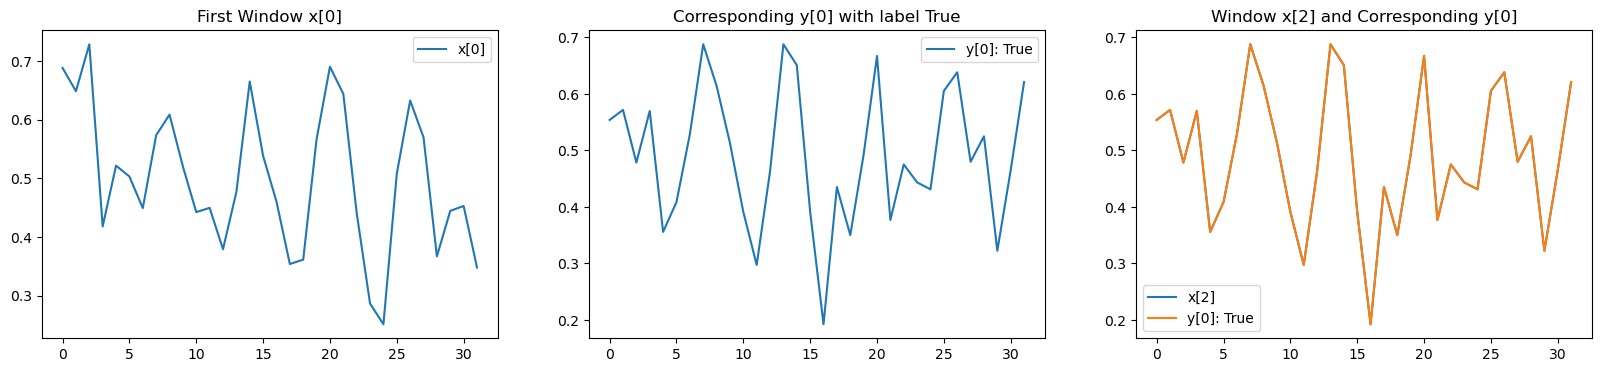

In [33]:
window_plot(0, x, y, labels)

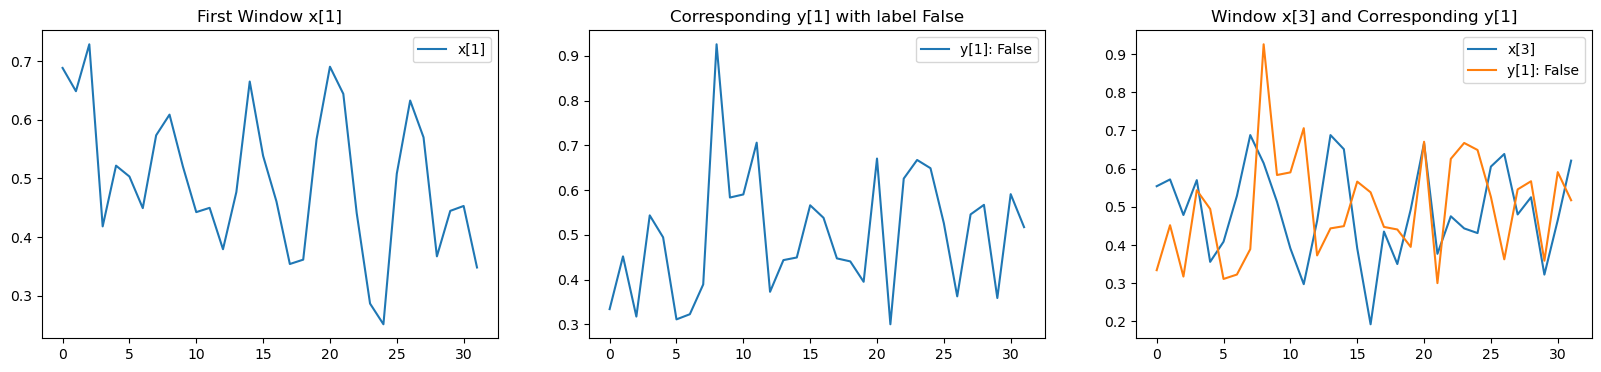

In [34]:
window_plot(1, x, y, labels)

# Model Architecture

In [76]:
# def network_encoder(x, code_size):
#     x = Conv1D(64, 3, activation='linear', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     x = Conv1D(64, 3, activation='linear', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     x = Conv1D(64, 3, activation='linear', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     x = Conv1D(64, 3, activation='linear', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     x = Dense(units=256, activation='linear')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
#     return x

def network_encoder(x, code_size):
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    # x = Dense(256, activation='linear')(x)
    x = Dense(256, activation='linear')(x)
    x = Flatten()(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    # x = Reshape((-1,1))(x)
    return x

In [77]:
code_size = 128
input_shape = (timesteps, features)

encoder_input = Input(input_shape)
encoder_output = network_encoder(encoder_input, code_size)
encoder_model = Model(encoder_input, encoder_output, name='encoder')
encoder_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 32, 1)]           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 32, 64)            256       
                                                                 
 conv1d_5 (Conv1D)           (None, 32, 64)            12352     
                                                                 
 dense_26 (Dense)            (None, 32, 256)           16640     
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 encoder_embedding (Dense)   (None, 128)               1048704   
                                                                 
Total params: 1,077,952
Trainable params: 1,077,952
Non-tra

In [78]:
x_input = Input(input_shape)
x_encoded = encoder_model(x_input)

# integrates information along the sequence
x_encoded = (Reshape((-1,1))(x_encoded))
context = GRU(256, return_sequences=False, name="context")(x_encoded)

# predict z-latent from context
preds = Dense(code_size, activation="linear", name="preds")(context)

y_input = Input(input_shape)
y_encoded = encoder_model(y_input)

dot_product = K.sum(y_encoded * preds, axis=-1)
# dot_product = K.batch_dot(y_encoded, preds, axes=1)
dot_product = K.sigmoid(dot_product)

model = Model(inputs=[x_input, y_input], outputs=dot_product, name='contrastive')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "contrastive"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 32, 1)]      0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 32, 1)]      0           []                               
                                                                                                  
 encoder (Functional)           (None, 128)          1077952     ['input_28[0][0]',               
                                                                  'input_29[0][0]']               
                                                                                                  
 reshape_5 (Reshape)            (None, 128, 1)       0           ['encoder[0][0]']      

2024-06-27 16:59:52.852664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-27 16:59:52.853653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-27 16:59:52.854980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [79]:
batch_size = 16
epochs = 3

train_gen = DataGenerator(x_train, batch_size=batch_size, shuffle=True)
test_gen = DataGenerator(x_test, batch_size=batch_size, shuffle=True)

model.fit(train_gen, batch_size=batch_size, epochs=epochs, validation_data=test_gen)

Epoch 1/3


2024-06-27 17:00:01.410045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-27 17:00:01.574513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-27 17:00:01.576139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

585/585 [==============================] - ETA: 0s - loss: 0.1599 - binary_accuracy: 0.9291

2024-06-27 17:00:43.430635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-27 17:00:43.538060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-27 17:00:43.538589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

585/585 [==============================] - 46s 77ms/step - loss: 0.1599 - binary_accuracy: 0.9291 - val_loss: 0.1082 - val_binary_accuracy: 0.9571
Epoch 2/3
585/585 [==============================] - 44s 75ms/step - loss: 0.0813 - binary_accuracy: 0.9719 - val_loss: 0.0601 - val_binary_accuracy: 0.9795
Epoch 3/3
585/585 [==============================] - 44s 76ms/step - loss: 0.0558 - binary_accuracy: 0.9795 - val_loss: 0.0444 - val_binary_accuracy: 0.9843


In [80]:
encoder_model.save("encoder_new.h5", include_optimizer=False)

# Downstream Task

In [17]:
# # Define the DataGenerator class with the windowing function
# class DownStreamGenerator(Sequence):
#     def __init__(self, data, timesteps, strides, batch_size=32, shuffle=True):
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.timesteps = timesteps
#         self.data = self.window(data, timesteps, strides)
#         self.indexes = np.arange(len(self.data) - 1)
#         self.on_epoch_end()
        
#     def window(self, data, timesteps, strides=1):
#         x = []
#         for i in range(0, len(data) - timesteps, strides):
#             x.append(data[i:i+timesteps])
#         return np.array(x)

#     def __len__(self):
#         return len(self.indexes) // self.batch_size

#     def __getitem__(self, batch):
#         x = []
#         y = []
#         indexes = self.indexes[batch*self.batch_size:(batch+1)*self.batch_size]
#         for idx in indexes:
#             x.append(self.data[idx])
#             y.append(self.data[idx+1, 0])  # Predict the next value of the first feature
#         return np.array(x), np.array(y)

#     def on_epoch_end(self):
#         if self.shuffle:
#             np.random.shuffle(self.indexes)

In [ ]:
# dsg = DownStreamGenerator(data, 32, strides=32, batch_size=16, shuffle=False)

# print(len(dsg))

# # get the first batch
# x, y = dg.__getitem__(0)
# print(f"x shape: {x.shape}, y shape: {y.shape}")

976
x shape: (16, 32, 1), y shape: (16, 32, 1), labels shape: (16, 1)


In [56]:
encoder_model = load_model('encoder_new.h5', compile=True)

encoder_model.trainable = False  # Freeze the encoder model

x_input = Input(input_shape)
x = encoder_model(x_input)
x = Reshape((-1, 1))(x)
x = GRU(128, return_sequences=False)(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

forecasting_model = Model(x_input, x)
forecasting_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32, 1, 1)]        0         
                                                                 
 encoder (Functional)        (None, 128)               1077952   
                                                                 
 reshape_2 (Reshape)         (None, 128, 1)            0         
                                                                 
 gru_1 (GRU)                 (None, 128)               50304     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,136,577
Trainable params: 58,625
Non-traina

2024-06-27 16:40:57.394350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-27 16:40:57.395687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-27 16:40:57.396358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [57]:
forecasting_model.compile(optimizer='adam', loss='mse')
forecasting_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10


2024-06-27 16:41:11.334486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-27 16:41:11.335306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-27 16:41:11.336241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

293/293 [==============================] - ETA: 0s - loss: 0.0092

2024-06-27 16:41:25.725821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-27 16:41:25.726307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-27 16:41:25.726767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

293/293 [==============================] - 16s 50ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 2/10
293/293 [==============================] - 14s 49ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 3/10
293/293 [==============================] - 14s 47ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 4/10
293/293 [==============================] - 14s 48ms/step - loss: 0.0089 - val_loss: 0.0092
Epoch 5/10
293/293 [==============================] - 14s 48ms/step - loss: 0.0089 - val_loss: 0.0093
Epoch 6/10
293/293 [==============================] - 14s 49ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 7/10
293/293 [==============================] - 14s 48ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 8/10
293/293 [==============================] - 15s 50ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 9/10
293/293 [==============================] - 15s 50ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 10/10
293/293 [==============================] - 15s 51ms/step - loss: 0.0089 - val_los

In [199]:
# Create a new model for forecasting
def create_forecasting_model(encoder_model, timesteps, features):
    encoder_model.trainable = False  # Freeze the encoder model
    input_shape = (timesteps, features)
    forecasting_input = Input(input_shape)
    
    encoded_representation = encoder_model(forecasting_input)
    
    # Reshape to 3D tensor (batch_size, timesteps, encoded_features)
    encoded_representation = Reshape((timesteps, -1))(encoded_representation)
    
    # Add your forecasting layers here
    x = GRU(128, return_sequences=False)(encoded_representation)
    x = Dense(64, activation='relu')(x)
    output = Dense(1)(x)  # Predicting the next point in the time series
    
    forecasting_model = Model(forecasting_input, output)
    forecasting_model.compile(optimizer='adam', loss='mse')
    return forecasting_model

In [200]:
# Create the forecasting model
forecasting_model = create_forecasting_model(encoder_model, timesteps, features)
forecasting_model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 32, 1)]           0         
                                                                 
 encoder (Functional)        (None, 128)               1077952   
                                                                 
 reshape_21 (Reshape)        (None, 32, 4)             0         
                                                                 
 gru_15 (GRU)                (None, 128)               51456     
                                                                 
 dense_35 (Dense)            (None, 64)                8256      
                                                                 
 dense_36 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,137,729
Trainable params: 59,777
Non-train

2024-06-27 15:46:10.723020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-27 15:46:10.723490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-27 15:46:10.723994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [201]:
# Train the forecasting model
epochs = 10
forecasting_model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/10


2024-06-27 15:46:10.775267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-27 15:46:10.912286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-27 15:46:10.913125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

136/136 [==============================] - ETA: 0s - loss: 0.0131

2024-06-27 15:46:13.181513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-27 15:46:13.297551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-27 15:46:13.298155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

136/136 [==============================] - 3s 15ms/step - loss: 0.0131 - val_loss: 0.0095
Epoch 2/10
136/136 [==============================] - 2s 14ms/step - loss: 0.0093 - val_loss: 0.0105
Epoch 3/10
136/136 [==============================] - 2s 13ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 4/10
136/136 [==============================] - 2s 12ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 5/10
136/136 [==============================] - 2s 12ms/step - loss: 0.0086 - val_loss: 0.0083
Epoch 6/10
136/136 [==============================] - 2s 12ms/step - loss: 0.0083 - val_loss: 0.0086
Epoch 7/10
136/136 [==============================] - 2s 12ms/step - loss: 0.0086 - val_loss: 0.0083
Epoch 8/10
136/136 [==============================] - 2s 12ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 9/10
136/136 [==============================] - 2s 13ms/step - loss: 0.0083 - val_loss: 0.0084
Epoch 10/10
136/136 [==============================] - 2s 12ms/step - loss: 0.0084 - val_loss: 0.0082


In [202]:
from sklearn.metrics import mean_absolute_error
# Generate predictions for the test set
predictions = forecasting_model.predict(forecasting_test_gen)

# Extract actual values from the test generator
actual_values = []
for _, y in forecasting_test_gen:
    actual_values.extend(y)
actual_values = np.array(actual_values)

# Calculate and print Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

2024-06-27 15:46:29.095244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-27 15:46:29.214341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-27 15:46:29.214935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

58/58 [==============================] - 0s 3ms/step
Mean Absolute Error (MAE): 0.1118773228693683


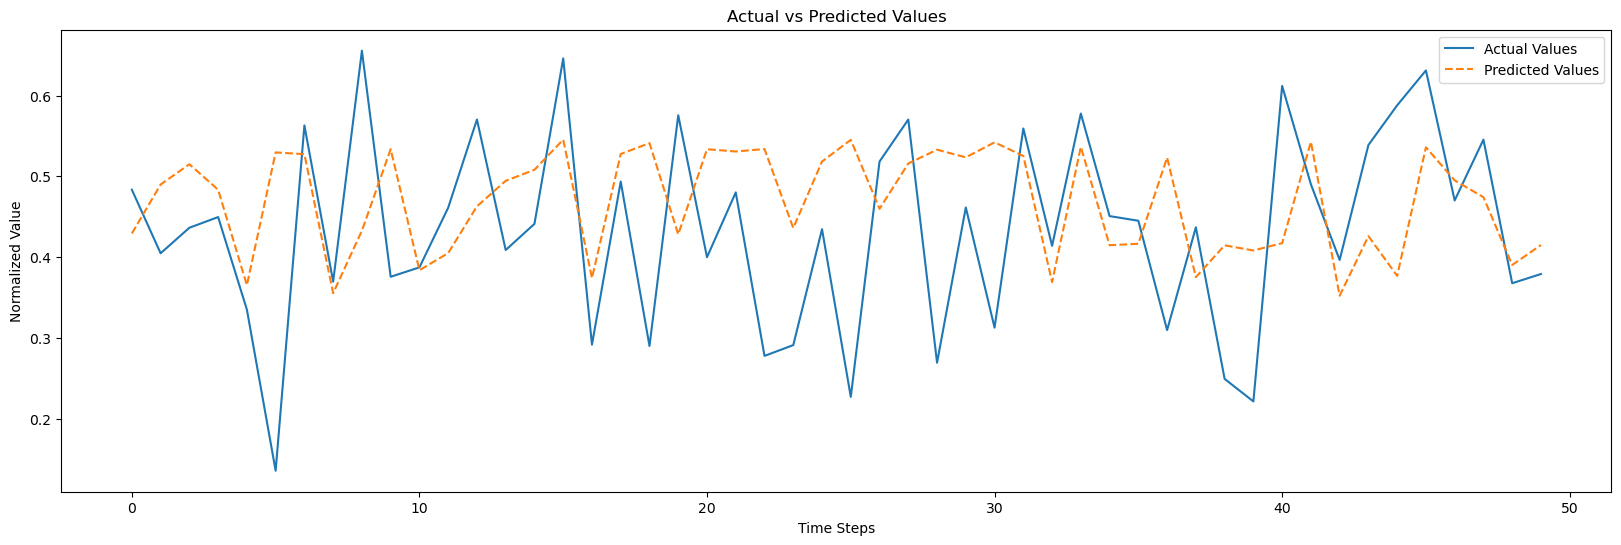

In [204]:
# Extract actual values from the test generator
actual_values = []
for _, y in forecasting_test_gen:
    actual_values.extend(y)
actual_values = np.array(actual_values)

# Plot the predictions against the actual values
plt.figure(figsize=(20, 6))
plt.plot(actual_values[:50], label='Actual Values')
plt.plot(predictions[:50], label='Predicted Values', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Value')
plt.show()

In [75]:
x_input = Input((32,1))
# x = Reshape((-1, 1))(x)
# x = GRU(128, return_sequences=False)(x_input)
x = Dense(64, activation='relu')(x)
x = Dense(1)(x)

forecasting_model = Model(x_input, x)
forecasting_model.compile(optimizer='adam', loss='mse')
forecasting_model.summary()
forecasting_model.fit(x_train, y_train, epochs=10, batch_size=16, validation_data=(x_test, y_test))

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 32, 1)]           0         
                                                                 
 dense_23 (Dense)            (None, 32, 64)            128       
                                                                 
 dense_24 (Dense)            (None, 32, 64)            4160      
                                                                 
 dense_25 (Dense)            (None, 32, 1)             65        
                                                                 
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
586/586 [==============================] - 1s 965us/step - loss: 0.0202 - val_loss: 0.0164
Epoch 2/10
586/586 [==============================] - 0s 754us/step - loss: 0.0165 - v

In [69]:
x_train.shape

(9374, 32, 1)